# Example 03 - Classification of an on-the-fly generated Sig53-like dataset
This notebook walks through a simple example of how to use the **clean** Sig53 dataset, load a pre-trained supported model, and evaluate the trained network's performance. Note that the experiment and the results herein are not to be interpreted with any significant value but rather serve simply as a practical example of how the `torchsig` dataset and tools can be used and integrated within a typical [PyTorch](https://pytorch.org/) and/or [PyTorch Lightning](https://www.pytorchlightning.ai/) workflow.

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit. An additional import from the `cm_plotter.py` helper script is also done here to retrieve a function to streamline plotting of confusion matrices.

In [1]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.utils.writer import DatasetCreator, DatasetLoader
from torchsig.datasets import conf
from pytorch_lightning.callbacks import ModelCheckpoint
from torchsig.utils.cm_plotter import plot_confusion_matrix
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torchsig.datasets.sig53 import Sig53
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torch
import os

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


----
### Instantiate Sig53 Dataset
Here, we instantiate the Sig53 clean training dataset and the Sig53 clean validation dataset. We demonstrate how to compose multiple TorchSig transforms together, using a data impairment with a random phase shift that uniformly samples a phase offset between -1 pi and +1 pi. The next transform normalizes the complex tensor, and the final transform converts the complex data to a real-valued tensor with the real and imaginary parts as two channels. We additionally provide a target transform that maps the `SignalDescription` objects, that are part of `SignalData` objects, to a desired format for the model we will train. In this case, we use the `DescToClassIndex` target transform to map class names to their indices within an ordered class list. Finally, we sample from our datasets and print details in order to confirm functionality.

For more details on the Sig53 dataset instantiations, please see the Sig53 example notebook.

In [2]:
train_config = conf.Sig53CleanTrainConfig

# Specify Options
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

train_dataset = ModulationsDataset(
    level=train_config.level,
    num_samples=train_config.num_samples,
    num_iq_samples=train_config.num_iq_samples,
    use_class_idx=train_config.use_class_idx,
    include_snr=False,
    eb_no=train_config.eb_no,
    transform=transform,
    target_transform=target_transform,
)

val_config = conf.Sig53CleanValConfig
val_dataset = ModulationsDataset(
    level=train_config.level,
    num_samples=val_config.num_samples,
    num_iq_samples=val_config.num_iq_samples,
    use_class_idx=val_config.use_class_idx,
    include_snr=False,
    eb_no=val_config.eb_no,
    transform=transform,
    target_transform=target_transform,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(train_dataset))
data, label = train_dataset[idx]
print("Dataset length: {}".format(len(train_dataset)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))


Dataset length: 1060000
Data shape: (2, 4096)
Label Index: 38


----
### Format Dataset for Training
Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

In [3]:
# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=os.cpu_count() // 2,
    num_workers=os.cpu_count() // 2,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=os.cpu_count() // 2,
    num_workers=os.cpu_count() // 2,
    shuffle=False,
    drop_last=True,
)

----
### Instantiate Supported TorchSig Model
Below, we load a pretrained EfficientNet-B4 model, and then conform it to a PyTorch LightningModule for training.

In [4]:
model = efficientnet_b4(
    pretrained=True,
    path="efficientnet_b4.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
class ExampleNetwork(LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleNetwork, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader

        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size

    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return self.data_loader

    def training_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        loss = F.cross_entropy(self(x.float()), y)
        return {"loss": loss}

    def val_dataloader(self):
        return self.val_data_loader

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        val_loss = F.cross_entropy(self(x.float()), y)
        self.log("val_loss", val_loss, prog_bar=True)
        return {"val_loss": val_loss}

example_model = ExampleNetwork(model, train_dataloader, val_dataloader)

----
### Train the Model
To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.

In [6]:
# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint_otf".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 2
trainer = Trainer(
    max_epochs=epochs,
    callbacks=checkpoint_callback,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=[1], # multi-GPU may not work in a notebook environment
)
trainer.fit(example_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type         | Params
--------------------------------------
0 | mdl  | EfficientNet | 17.3 M
--------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.085    Total estimated model params size (MB)


Epoch 1: 100%|██████████| 16562/16562 [1:13:45<00:00,  3.74it/s, v_num=9, val_loss=0.112] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 16562/16562 [1:13:45<00:00,  3.74it/s, v_num=9, val_loss=0.112]


----
### Evaluate the Trained Model
After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.

In [7]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

In [8]:
# Infer results over validation set
num_test_examples = len(val_dataset)
num_classes = len(list(Sig53._idx_to_name_dict.values()))
y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = val_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|██████████| 106000/106000 [44:12<00:00, 39.97it/s]


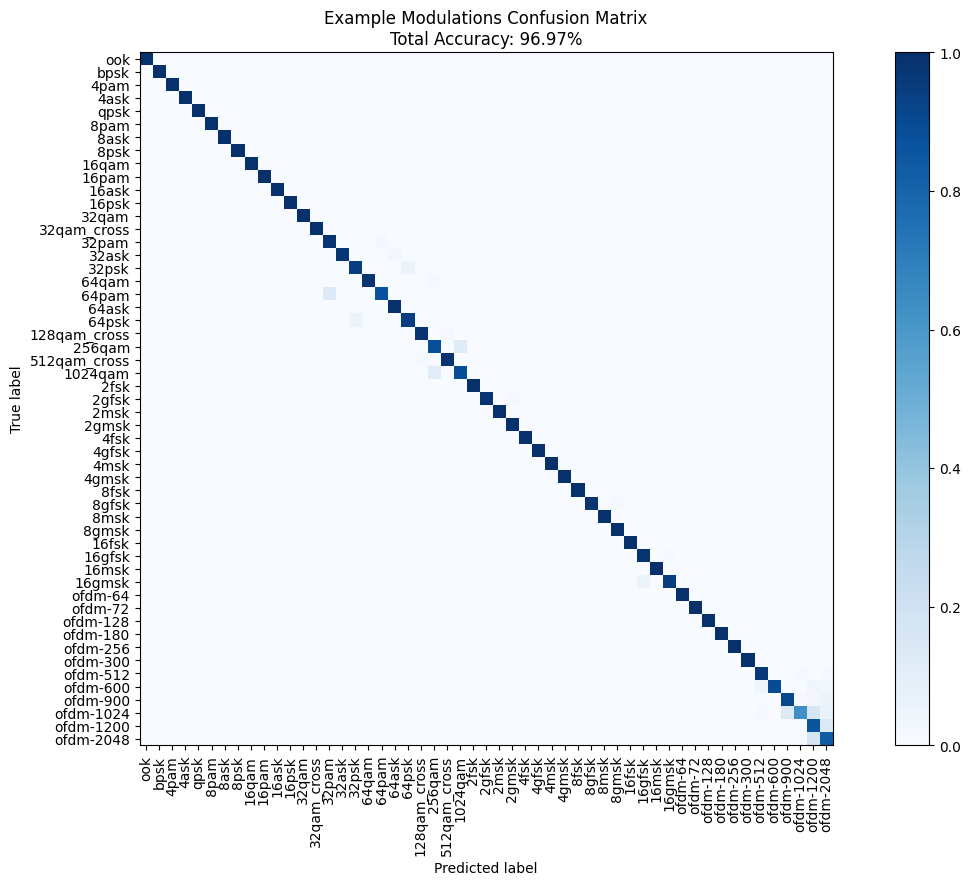

In [9]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

In [10]:
print("Classification Report:")
print(classification_report(y_true, y_preds))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2000
         1.0       1.00      1.00      1.00      2000
         2.0       1.00      1.00      1.00      2000
         3.0       1.00      1.00      1.00      2000
         4.0       1.00      1.00      1.00      2000
         5.0       1.00      1.00      1.00      2000
         6.0       1.00      1.00      1.00      2000
         7.0       1.00      1.00      1.00      2000
         8.0       1.00      1.00      1.00      2000
         9.0       1.00      1.00      1.00      2000
        10.0       1.00      1.00      1.00      2000
        11.0       1.00      1.00      1.00      2000
        12.0       1.00      1.00      1.00      2000
        13.0       1.00      1.00      1.00      2000
        14.0       0.89      0.98      0.93      2000
        15.0       1.00      0.97      0.99      2000
        16.0       0.94      0.94      0.94      2000
    